### Заргрузка данных:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')

In [3]:
orders = pd.read_csv('orders.csv')

In [4]:
visitors = pd.read_csv('visitors.csv')

In [5]:
hypothesis.info()
print('Дубликатов:', hypothesis.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Дубликатов: 0


In [6]:
orders.info()
print('Дубликатов:', orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Дубликатов: 0


In [7]:
visitors.info()
print('Дубликатов:',visitors.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Дубликатов: 0


### Вывод:
на мой взгляд с данными все впорядке, можно продолжать.


### Приоретизация гипотез:

In [8]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis['ICE'] = hypothesis['ICE'].map(lambda n: '{:.2f}'.format(n))

In [9]:
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00


Гипотезы 8,0,7,6 самые перспективные.

In [10]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.0


При расчете RICE так же как и при расчете ICE гипотезы 0 и 6 оказались приорететными, но с наименьшим охватом пользователей.

### Вывод:

Разница при расчете RICE вместо ICE возникла, потому что при расчете RICE учитывается охват пльзователей. В результате приортетными гипотезами оказались 7,2,0,6 по моему мнению это произошло из за высокого уровня Impact то есть силу влияния изменений на пользователя

### Анализ A/B теста:

Построим график коммулятивной выручки по гурппам:

In [11]:
datesGroups = orders[['date','group']].drop_duplicates()

In [12]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [13]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [14]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [15]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [16]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

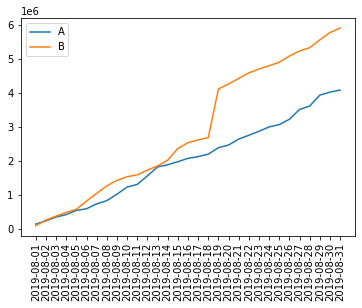

In [17]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation='vertical')
plt.legend()

До оперделенного момента выручки обеих групп росли примерно одинаково, но потом в группе B произошел резкий скачок. Это говорит о появлении либо большого количества заказов, лиюо о большой выручке. Построим график коммулятивного среднего чека по группам:

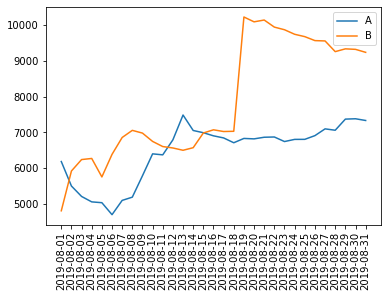

In [18]:
plt.plot(cumulativeRevenueA['date'],
cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'],
cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation='vertical')
plt.legend()

 Средний чек группы B вырос в том жеинтервале дат, видим дело в аномально большой выручке. Построим график относительного изменения кумулятивного среднего чека группы B к группе A:

In [19]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A','B'])

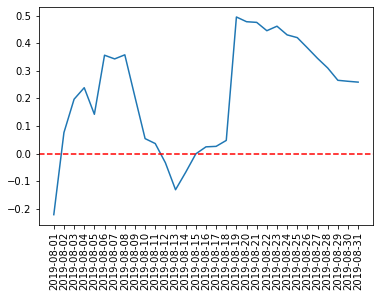

In [20]:
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation='vertical')
plt.axhline(y=0, color='red', linestyle ='--')

график очень сильно скачет, полагаю что все же дело в большоей выручке. Построим  график кумулятивной конверсии по группам:

In [21]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

In [22]:
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

In [23]:
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

(0.0, 30.0, 0.02, 0.05)

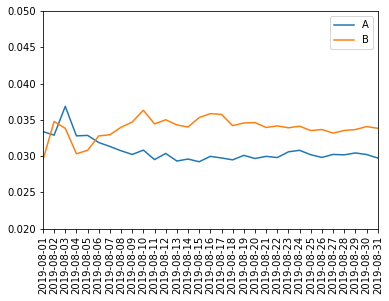

In [24]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation='vertical')
plt.axis(["2019-08-01", '2019-08-31', 0.02, 0.05])

Конверсия по группам получилась симметричной, хоть и вначале были колебания. Построим график относительного различия кумулятивных конверсий:

In [25]:
mergedCumulativeCoversions =cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']],left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

(0.0, 30.0, -0.15, 0.23)

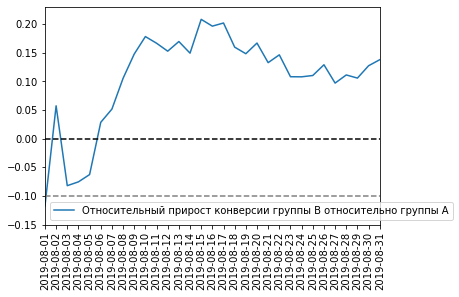

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation='vertical')
plt.axis(["2019-08-01", '2019-08-31', -0.15, 0.23])

Конверсия группы B чуть больше чем конверсия группы А. Построим точечный график стоимостей заказов:

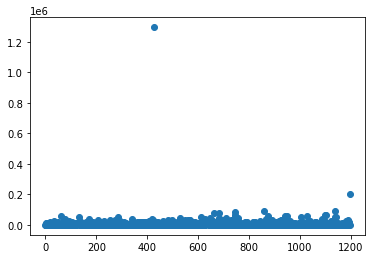

In [27]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

Как и предполагалось есть несколько очень больших заказов, это привело к тому что в группе B произошел резкий скачок выручки и увеличению среднего чека. Посчитаем 95-й и 99-й перцентили стоимости заказов:

Большой заказ привел к тому что в группе B произошел резкий скачок выручки и увеличению среднего чека.

In [28]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Вывод: не более 5% заказов дороже 28000 и не более 1% заказов дороже 58233.2. Построим точечный график стоимостей заказов

In [29]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})
ordersByUsers.columns = ['userId','orders']

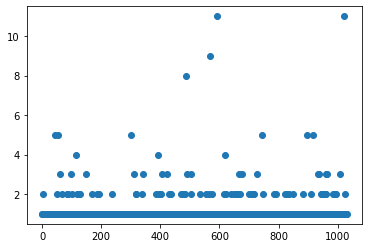

In [30]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])

много пользователей с 2-4 заказами. Теперь посчитаем 95-й и 99-й перцентили количества заказов на пользователя:

In [31]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5 % пользователей совершили 2 покупки, и не больше 1% совершили более 4 покупок. Считаю что границу заказов на одного пользователя стоит установить в диапозозоне до 3 заказов. Теперь подготовим данные для дальнейших расчетов:

In [32]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [33]:
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [34]:
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [35]:
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [36]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [37]:
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [38]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [39]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [40]:
ab_data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

Далее посчитаем статистическую значимость различий конверсий между группами по «сырым» данным:

In [41]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

In [42]:
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

In [43]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(ab_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [44]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(ab_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [45]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.008
0.138


p-value меньше 0.05 значит нулевую гипотезу о том что значимых различий между грпппами нет нужно отвергнуть. Относитльно конверсия группы B больше на 13.8% 

Теперь посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.
Так как критерий Манн Уитни позволяет работать с рангами, а не со значениями, а в наших данных есть выбросы(большая выручка) то используем именно этот метод:

In [46]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


P-value больше 0.05, значит причин полагать что есть значительные различия в среднем чеке, нет. 
Далее расчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным:

In [47]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [48]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(ab_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

In [49]:
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(ab_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [50]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.009
0.144


Результаты по очещенным данным практически не изменились. Теперь посмотрим статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным:

In [51]:
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.490
-0.017


p-value увеличился, а вот относительная разница среднего чека группы B изменилась в отрицательную сторону, но не сильно. Уменьшение относительной разницы чека группа B возможно связанно с аномально большими выручками, которые были отсеяны.

### Вывод:

---
- До оперделенного момента выручки обеих групп росли примерно одинаково, но потом в группе B произошел резкий скачок.
- Средний чек группы B вырос в том жеинтервале дат, видим дело в аномально большой выручке
- Конверсия по группам получилась симметричной, хоть и вначале были колебания
- не более 5% заказов дороже 28000 и не более 1% заказов дороже 58233.2.
- Не более 5 % пользователей совершили 2 покупки, и не больше 1% совершили более 4 покупок.
- статистическая значимость различий конверсий между группами по «сырым» данным:
p-value меньше 0.05 значит нулевую гипотезу о том что значимых различий между грпппами нет нужно отвергнуть. Относитльно конверсия группы B больше на 13.8%
- посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным:
P-value больше 0.05, значит причин полагать что есть значительные различия в среднем чеке, нет.
- статистическая значимость различий в конверсии между группами по «очищенным» данным: практически не изменилась.
- статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным:
p-value увеличился, а вот относительная разница среднего чека группы B изменилась в отрицательную сторону.

Предполагаю что нужно продолжить тест и собрать больше данных, так как на данном этапе статистически значимой разницы между граппами нет.

---